# 0. Imports

### 0.1 Libs

In [1]:
import warnings
import inflection
import re

import numpy    as np
import pandas   as pd
import seaborn  as sns
import nbformat
import umap.umap_ as umap


from IPython.display        import Image
from scipy                  import stats            as ss
from plotly                 import express          as px
from matplotlib             import pyplot           as plt
from sklearn                import cluster          as c
from sklearn                import metrics          as m
from sklearn                import preprocessing    as pp

from yellowbrick.cluster    import KElbowVisualizer, SilhouetteVisualizer

/home/vitor/.pyenv/versions/3.9.0/envs/LoyaltyProgram/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 0.2 Helper Functions

In [2]:
warnings.simplefilter("ignore")

def numerical_metrics(numerical_attributes):
    #ct = central tendency
    ct_mean = pd.DataFrame(numerical_attributes.apply(np.mean)).T
    ct_median = pd.DataFrame(numerical_attributes.apply(np.median)).T

    #d = dispersion
    d_std = pd.DataFrame(numerical_attributes.apply(np.std)).T
    d_min = pd.DataFrame(numerical_attributes.apply(min)).T
    d_max = pd.DataFrame(numerical_attributes.apply(max)).T
    d_range = pd.DataFrame(numerical_attributes.apply(lambda x: x.max() - x.min())).T
    d_skew = pd.DataFrame(numerical_attributes.apply(lambda x: x.skew())).T
    d_kurtosis = pd.DataFrame(numerical_attributes.apply(lambda x: x.kurtosis())).T

    m = pd.concat([d_min,d_max,d_range,ct_mean,ct_median,d_std,d_skew,d_kurtosis]).T.reset_index()
    m.columns=['Attributes','Min','Max','Range','Mean','Median','STD','Skew','Kurtosis']

    return m

# Cramér's V
def cramer_v(x,y):
    cm = pd.crosstab( x, y).values               
    n = cm.sum()                                 
    r, k = cm.shape                             
    chi2 = ss.chi2_contingency(cm)[0]

    chi2corr = max( 0, chi2 - ((k-1)*(r-1))/(n-1) )
    kcorr = k-(k-1)**2/(n-1)
    rcorr = r-(r-1)**2/(n-1)

    # Cálculo do Cramér's V:
    return np.sqrt ( (chi2corr/n) / (min(kcorr-1, rcorr-1)) )



### 0.3 Loading Data

In [3]:
df_raw = pd.read_csv('../data/data.csv', encoding= 'unicode_escape')

# 1. Data Description

### 1.0 Rename Columns

In [4]:
df1 = df_raw.copy()

df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [5]:
cols_old = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country']

snakecase = lambda x: inflection.underscore(x)

cols_new = list( map(snakecase, cols_old))

df1.columns = cols_new

df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


### 1.1 Data Dimentions

In [6]:
print(f'Number of Rows:{df1.shape[0]}')
print(f'Number of Columns:{df1.shape[1]}')

Number of Rows:541909
Number of Columns:8


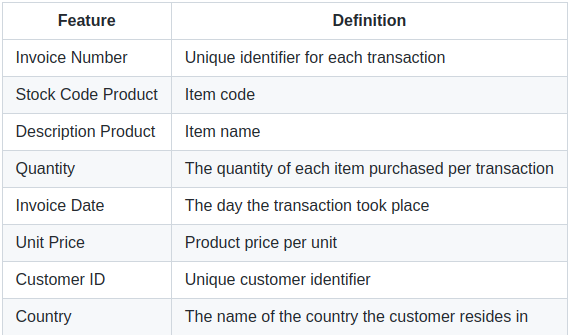

In [7]:
Image('../image/features_description.png')

### 1.2 Data Types

In [8]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

### 1.3 Check NA

In [9]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

### 1.4 Fillout NA

In [10]:
# Para avançar com o projeto de forma rápida, vamos retirar os registros com valores faltantes. 
# Posteriormente serão analisadas outras possibilidades de tratar esses dados.

df1 = df1.dropna(subset=['description', 'customer_id'])
print('Removed data: {:.0%}'.format( 1-(df1.shape[0] / df_raw.shape[0])))
print(f'New number of rows: {df1.shape[0]}')

Removed data: 25%
New number of rows: 406829


### 1.5 Change Types

In [11]:
df1['customer_id'] = df1['customer_id'].astype(int)
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'])

In [12]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

### 1.6 Descriptive Statistics

#### 1.6.0  Datasets

In [13]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])


#### 1.6.1 Nummerical Attributes

In [14]:
numerical_metrics(num_attributes)

,Attributes,Min,Max,Range,Mean,Median,STD,Skew,Kurtosis
0,quantity,-80995.0,80995.0,161990.0,12.061303,5.00,248.693064,0.182663,94317.563673
1,unit_price,0.0,38970.0,38970.0,3.460471,1.95,69.315077,452.219019,246924.542988
2,customer_id,12346.0,18287.0,5941.0,15287.690570,15152.00,1713.598197,0.029835,-1.179982


<font color = 'red'> Attention Points </font>

1. Negative Quantity
2. Unit price equal zero

#### 1.6.2 Categorical Attributes

In [15]:
cat_attributes.head()

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


##### Invoice No

In [50]:
# The invoice_no should be a number
# df1['invoice_no'].astype(int) --> dá erro pois alguns registros possuem letras no código

# Quantidade de registros com letras
df_letter_invoice = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), :]

df_letter_invoice

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315,United Kingdom


In [52]:
print(f'Total invoice_no with letter: {len(df_letter_invoice)}')
print('Total invoice_no with letter and negative quantity value: {}'.format(len(df_letter_invoice[df_letter_invoice['quantity']<0])))

Total invoice_no with letter: 8905
Total invoice_no with letter and negative quantity value: 8905


##### Stock Code

In [54]:
# The stock_code should be a number
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), :]


,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
45,536370,POST,POSTAGE,3,2010-12-01 08:45:00,18.00,12583,France
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
386,536403,POST,POSTAGE,1,2010-12-01 11:27:00,15.00,12791,Netherlands
1123,536527,POST,POSTAGE,1,2010-12-01 13:04:00,18.00,12662,Germany
2239,536569,M,Manual,1,2010-12-01 15:35:00,1.25,16274,United Kingdom
...,...,...,...,...,...,...,...,...
541216,581494,POST,POSTAGE,2,2011-12-09 10:13:00,18.00,12518,Germany
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498,United Kingdom
541730,581570,POST,POSTAGE,1,2011-12-09 11:59:00,18.00,12662,Germany
541767,581574,POST,POSTAGE,2,2011-12-09 12:09:00,18.00,12526,Germany


In [55]:
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()

# task: remove stock_code in ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']


array(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'], dtype=object)

##### Description

In [58]:
# Nesse ciclo a Description não parece ser importante para a melhoria do algoritmo

# Task: delete description

3896

##### Country

In [61]:
len(df1['country'].unique())

37

In [59]:
df1['country'].value_counts(normalize = True)

United Kingdom          0.889509
Germany                 0.023339
France                  0.020871
EIRE                    0.018398
Spain                   0.006226
Netherlands             0.005828
Belgium                 0.005086
Switzerland             0.004614
Portugal                0.003638
Australia               0.003095
Norway                  0.002669
Italy                   0.001974
Channel Islands         0.001863
Finland                 0.001708
Cyprus                  0.001529
Sweden                  0.001136
Austria                 0.000986
Denmark                 0.000956
Japan                   0.000880
Poland                  0.000838
USA                     0.000715
Israel                  0.000615
Unspecified             0.000600
Singapore               0.000563
Iceland                 0.000447
Canada                  0.000371
Greece                  0.000359
Malta                   0.000312
United Arab Emirates    0.000167
European Community      0.000150
RSA       

In [63]:
df1[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending=False)

,country,customer_id
35,United Kingdom,3950
14,Germany,95
13,France,87
30,Spain,31
3,Belgium,25
32,Switzerland,21
26,Portugal,19
18,Italy,15
12,Finland,12
1,Austria,11


# 2. Data Filtering 

In [64]:
df2 = df1.copy()

In [65]:
# ==== Cat Attributes ====

# Stock Code != ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK', 'C2'])]

# Description
df2 = df2.drop(columns = 'description', axis = 1)

# Country
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]


# ==== Num Attributes ====

# Unit Price > 0.04 
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# Quantity
df_returns = df2.loc[df2['quantity']<0, :]
df_purchases = df2.loc[df2['quantity']>0, :]


# 3. Feature Engineering

### 3.1 News Features

In [72]:
df3 = df2.copy()

In [73]:
# Data Reference
df_ref = df3.drop (['invoice_no', 'stock_code',
                    'quantity', 'invoice_date', 'unit_price',
                    'country'], axis=1).drop_duplicates(ignore_index=True)

In [74]:
# Monetary (Gross Revenue)
df_purchases['gross_revenue'] = df_purchases['quantity'] * df_purchases['unit_price']
df_monetary = df_purchases[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge (df_ref, df_monetary, on = 'customer_id', how = 'left')

df_ref.isna().sum()

customer_id       0
gross_revenue    27
dtype: int64

In [75]:
# Recency
df_recency = df_purchases[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df_purchases['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on = 'customer_id', how = 'left')

df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
dtype: int64

In [76]:
# Frequency
df_freq = df_purchases[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref, df_freq, on = 'customer_id', how = 'left')

df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
invoice_no       27
dtype: int64

In [77]:
# Avg Ticket
df_avg_ticket = df_purchases[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id', how='left')

df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
invoice_no       27
avg_ticket       27
dtype: int64

In [78]:
# Return Number
df_returns = df_returns[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns={'invoice_no' : 'returns'})
df_ref = pd.merge(df_ref, df_returns, how = 'left', on='customer_id')
df_ref.loc[df_ref['returns'].isna(), 'returns'] = 0

df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
invoice_no       27
avg_ticket       27
returns           0
dtype: int64

In [79]:
df_ref.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,returns
0,17850,5391.21,371.0,34.0,18.152222,1.0
1,13047,3232.59,56.0,9.0,18.904035,7.0
2,12583,6705.38,2.0,15.0,28.902500,2.0
3,13748,948.25,95.0,5.0,33.866071,0.0
4,15100,876.00,333.0,3.0,292.000000,3.0


# 4. Exploratory Data Analysis

In [81]:
df4 = df_ref.dropna().copy()

df4.isna().sum()

customer_id      0
gross_revenue    0
recency_days     0
invoice_no       0
avg_ticket       0
returns          0
dtype: int64

# 5. Data Preparation

In [98]:
df5 = df4.copy()

df5.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,returns
0,17850,5391.21,371.0,34.0,18.152222,1.0
1,13047,3232.59,56.0,9.0,18.904035,7.0
2,12583,6705.38,2.0,15.0,28.902500,2.0
3,13748,948.25,95.0,5.0,33.866071,0.0
4,15100,876.00,333.0,3.0,292.000000,3.0


In [99]:
# Standatization

ss = pp.StandardScaler()

df5['gross_revenue']    = ss.fit_transform(df5[['gross_revenue']])
df5['recency_days']     = ss.fit_transform(df5[['recency_days']])
df5['invoice_no']       = ss.fit_transform(df5[['invoice_no']])
df5['avg_ticket']       = ss.fit_transform(df5[['avg_ticket']])
df5['returns']          = ss.fit_transform(df5[['returns']])


# 6. Feature Selection

In [100]:
df6 = df5.copy()

# 7. Hyperparameter Fine-Tunning

### 7.0 Dataset

In [101]:
df6.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,returns
0,17850,0.378060,2.786689,3.893137,-0.033930,0.114690
1,13047,0.135805,-0.355762,0.621606,-0.033418,3.158261
2,12583,0.525545,-0.894468,1.406774,-0.026613,0.621952
3,13748,-0.120559,0.033303,0.098161,-0.023235,-0.392571
4,15100,-0.128667,2.407600,-0.163561,0.152452,1.129214


In [102]:
df7 = df6.drop(columns = ['customer_id'])

### 7.1 Within-Cluster Sum of Square (WSS)

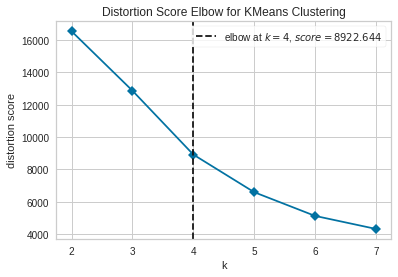

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [103]:
clusters = [2, 3, 4, 5, 6, 7]

# model definition
kmeans = KElbowVisualizer(c.KMeans(),
                          k = clusters,
                          timings = False)
# model training
kmeans.fit ( df7 )

# plot
kmeans.show()

### 7.2 Silhouette Score

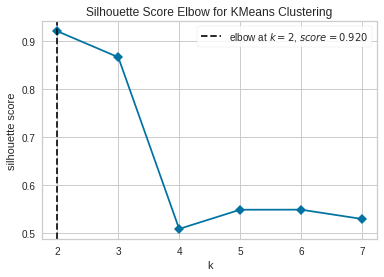

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [104]:
# Yellow Brick

# model definition
kmeans = KElbowVisualizer(c.KMeans(),
                          k = clusters,
                          metric='silhouette',
                          timings = False)

# model training
kmeans.fit ( df7 )

# plot
kmeans.show()

### 7.3 Silhouette Analysis

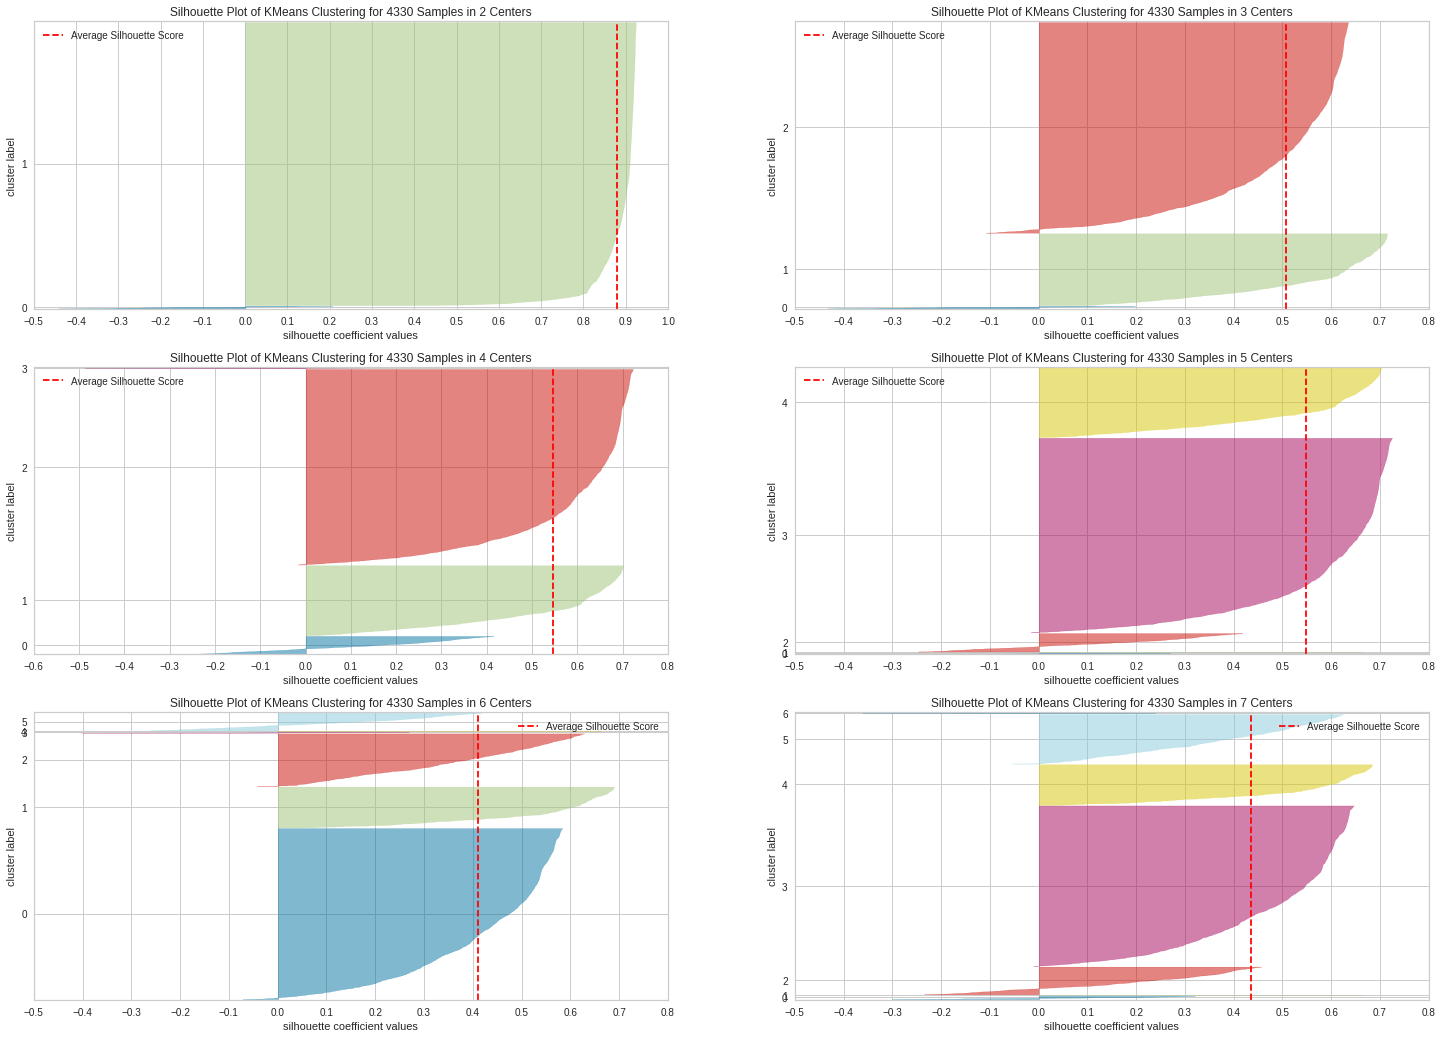

In [105]:
fig, ax = plt.subplots(3, 2, figsize=(25,18))

for k in clusters:
    km = c.KMeans(n_clusters=k,
                    init='random',
                    n_init=10,
                    max_iter=100,
                    random_state=42)
    q, mod = divmod(k, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(df7)
    visualizer.finalize()

# 8. Machine Learning Modelling

### 8.1 K-Means

In [106]:
X = df7.copy()

In [115]:
# model definition
k=3
kmeans = c.KMeans(init='random',
                  n_clusters=k,
                  n_init=10,
                  max_iter=300,
                  random_state=42)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

### 8.2 Cluster Validation

In [116]:
# WSS
print(f'WSS Value:{kmeans.inertia_}')

# SS
print('SS Value: {}'.format(m.silhouette_score(X, labels, metric='euclidean')))

WSS Value:13085.120627259257
SS Value: 0.5063786081446678


# 9. Evaluation - Cluster Analysis

### 9.1 Visualization Inspection

In [117]:
df9 = df6.copy()
df9['cluster'] = labels
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,returns,cluster
0,17850,0.378060,2.786689,3.893137,-0.033930,0.114690,1
1,13047,0.135805,-0.355762,0.621606,-0.033418,3.158261,2
2,12583,0.525545,-0.894468,1.406774,-0.026613,0.621952,2
3,13748,-0.120559,0.033303,0.098161,-0.023235,-0.392571,2
4,15100,-0.128667,2.407600,-0.163561,0.152452,1.129214,1


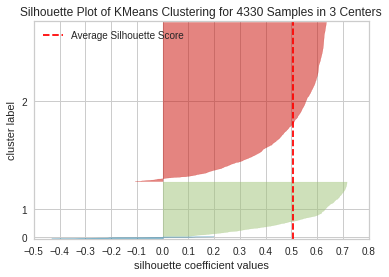

In [118]:
# Silhouette Viz:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

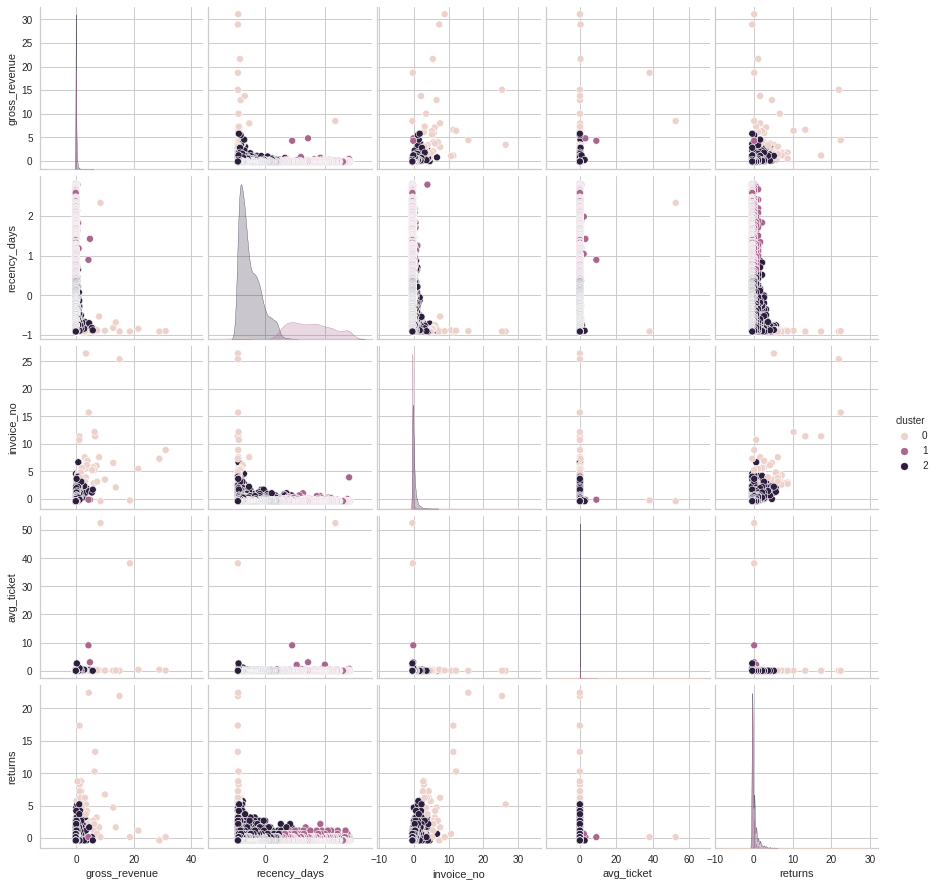

In [119]:
# 2D Plot (Pair Plot)
df_viz = df9.drop(columns='customer_id', axis=1)
sns.pairplot(df_viz, hue='cluster')

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

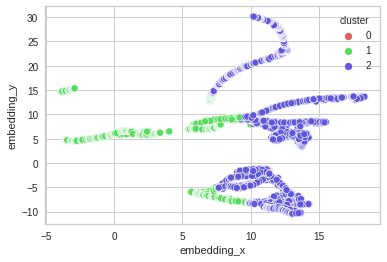

In [120]:
# UMAP (mais rápido para grandes quantidades de dados) / t-SNE (mais preciso, porém mais lento): 
    # abordagem por Manifold (topologia) - projeção de altas dimensões em 3D ou 2D sem perder suas características principais

reducer = umap.UMAP(n_neighbors=40, random_state=42)
embedding = reducer.fit_transform (X)

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plto UMAP
sns.scatterplot( x='embedding_x',
                 y='embedding_y',
                 hue='cluster',
                 palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())),
                 data = df_viz)

### 9.2 Cluster Profile

In [121]:
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,returns,cluster
0,17850,0.378060,2.786689,3.893137,-0.033930,0.114690,1
1,13047,0.135805,-0.355762,0.621606,-0.033418,3.158261,2
2,12583,0.525545,-0.894468,1.406774,-0.026613,0.621952,2
3,13748,-0.120559,0.033303,0.098161,-0.023235,-0.392571,2
4,15100,-0.128667,2.407600,-0.163561,0.152452,1.129214,1


In [122]:
# Number of customer
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = (df_cluster['customer_id'] / df_cluster['customer_id'].sum())*100

# Avg gross revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on = 'cluster')

# Avg recency
df_avg_recency = df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency, how='inner', on='cluster')

# Avg invoice_no
df_avg_invoice_no = df9[['invoice_no', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_invoice_no, how='inner', on='cluster')

# Avg ticket
df_ticket = df9[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_ticket, how='inner', on='cluster')


df_cluster


,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,40,0.923788,6.685399,-0.794209,6.500548,2.308958
1,1,1091,25.196305,-0.165221,1.532827,-0.351757,-0.008771
2,2,3199,73.879908,-0.027246,-0.512831,0.038682,-0.025880


Cluster 01 (Candidado a Insider):
- Total Customers: 6 (0,14% of total)
- Avg Recency: 7 days
- Avg frequency: 89 purchase
- Avg Revenue: $ 182,181.98

Cluster 02:
- Total Customers: 31 (0,71% of total)
- Avg Recency: 14 days
- Avg frequency: 53 purchase
- Avg Revenue: $ 40,543.52

Cluster 03:
- Total Customers: 4,335 (99% of total)
- Avg Recency: 92 days
- Avg frequency: 5 purchase
- Avg Revenue: $ 1,372.58

# 10. Deploy To Production